In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt

In [153]:
# Data Generation
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)

print(a, b)

# Sets learning rate
lr = 1e-1
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Computes our model's predicted output
    yhat = a + b * x_train
    
    # How wrong is our model? That's the error! 
    error = (y_train - yhat)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()
    
    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()
    
    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad
    
print(a, b)

# Sanity Check: do we get the same results as our gradient descent?
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])

[0.49671415] [-0.1382643]
[1.02354094] [1.96896411]
[1.02354075] [1.96896447]


In [66]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())


<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.FloatTensor
tensor([0.7544], requires_grad=True) tensor([-1.4796], requires_grad=True)


In [74]:
lr = 1e-1
n_epochs = 1000

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    # No more manual computation of gradients! 
    # a_grad = -2 * error.mean()
    # b_grad = -2 * (x_tensor * error).mean()
    
    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()
    # Let's check the computed gradients...
    if epoch%200 == 0:
        print(a.grad)
        print(b.grad)   
    
    # THIRD ATTEMPT
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    
    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    a.grad.zero_()
    b.grad.zero_()
    
print(a, b)

tensor([-3.1125])
tensor([-1.8156])
tensor([0.0043])
tensor([-0.0085])
tensor([0.0002])
tensor([-0.0004])
tensor([9.8259e-06])
tensor([-1.9239e-05])
tensor([5.2573e-07])
tensor([-9.6788e-07])
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


In [100]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    
    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat)

    loss.backward()    
    
    # No more manual update!
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    optimizer.step()
    
    # No more telling PyTorch to let gradients go!
    # a.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()
    
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


In [96]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.linear(x)

In [95]:
from torch.utils.data import Dataset, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

OrderedDict([('linear.weight', tensor([[1.9698]])), ('linear.bias', tensor([1.0246]))])


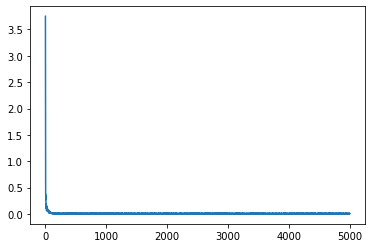

In [101]:
from torch.utils.data import DataLoader

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
train_data = CustomDataset(x_train_tensor, y_train_tensor)

# Now we can create a model and send it at once to the device
model = LayerLinearRegression().to(device)

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

losses = []

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Activate train mode
        model.train()

        # No more manual prediction!
        # yhat = a + b * x_tensor
        yhat = model(x_batch)

        loss = loss_fn(y_batch, yhat)
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())
        
print(model.state_dict())
plt.plot(losses)
plt.show()

In [103]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [270]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(2, 5),
      nn.ReLU(),
      nn.Linear(5, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

In [271]:
from torch.utils.data.dataset import random_split

x = np.linspace(-10, 10, 100)
y = np.sin(x/10)*np.exp(-(x/5)**2)
x_aug = np.array([x, -np.sin(x/10)])


x_tensor = torch.from_numpy(x_aug.reshape(-1, 2)).float()
y_tensor = torch.from_numpy(y.reshape(-1, 1)).float()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=10)

In [311]:
# model = LayerLinearRegression().to(device)
model = MLP().to(device)

loss_fn = nn.MSELoss(reduction='mean')
# optimizer = optim.SGD(model.parameters(), lr=1e-1)
optimizer=optim.Adam(model.parameters(),lr=0.013)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9995)

losses = []
val_losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(5*n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())
    
    scheduler.step()

print(model.state_dict())

5.042986958869733e-05
0.00021108283544890583


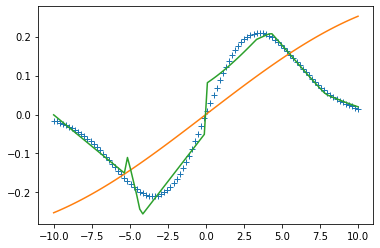

In [309]:
plt.plot(x, y, "+")
plt.plot(x, -0.3*x_aug[1])
plt.plot(x, model(x_tensor).detach().numpy())
# plt.plot(losses)
print(min(losses))
print(min(val_losses))
plt.show()

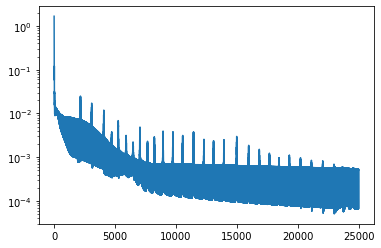

10000

In [310]:
plt.plot(losses)
plt.yscale('log')
plt.show()
len(val_losses)

In [ ]:
# x, SGD
5.5483014875790104e-05
3.3537820854689926e-05

# x, -sin(x/10)
3.322373595437966e-05
0.0001521195808891207


# Adam:
3.534929419402033e-05
0.0005629080696962774

# variable lr
2.147051054635085e-05
2.3551257982035168e-05

# Optimzing lr
1.530365443613846e-05
1.0629438293108251e-05